In [171]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import pandas as pd

In [172]:
force_cpu = True
if not force_cpu:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Using device", device)


Using device cpu


In [173]:
class JointDataset(Dataset): 
    def __init__(self, x, joint_names):
        super().__init__()
        self.x = self.scale(x)
        self.joint_names = joint_names
        self.furthest_distance = None
        self.centroid = None
    
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        return self.x[idx]
    
    def scale(self, x):
        # Center the points and reduce to unit-sphere
        x = x.reshape(-1, 3)
        self.centroid = torch.mean(x, axis=0)
        x -= self.centroid
        self.furthest_distance = torch.max(torch.sqrt(torch.sum(x**2,axis=-1)))
        x /= self.furthest_distance
        # Put back into the original shape
        x = x.reshape(-1, 32, 3)
        return x
        
    def unscale(self):
        x = self.x.clone()
        if self.furthest_distance is None:
            raise ValueError("Dataset has not been scaled yet")
        x *= self.furthest_distance
        x += self.centroid
        return x


def make_joint_dataset(device: torch.device):
    
    with open("data/unlabelled/camera/joints/front_sit_stand.csv") as f:
        data = pd.read_csv(f, header=0)
        data = data.rename(columns={
            "x-axis": "x", 
            "y-axis": "y", 
            "z-axis": "z",
            "joint_names": "joint_name"
        })
        print(data.head())
    
    # Get the unique joint names and frame IDs
    joint_names = np.sort(data["joint_name"].unique())
    frame_ids = data["frame_id"].unique()
    
    # Create a multi-index using 'frame_id' and 'joint_names'
    data.set_index(['frame_id', 'joint_name'], inplace=True)
    
    # Sort the index to ensure the data is in the correct order
    data.sort_index(inplace=True)
    
    # Convert the DataFrame to a NumPy array and reshape it
    x = data[['x', 'y', 'z']].values.reshape((frame_ids.size, joint_names.size, 3))
    
    # Convert the NumPy array to a PyTorch tensor
    x = torch.from_numpy(x).float().to(device)
    
    dataset = JointDataset(
        joint_names=joint_names,
        x=x)
    return dataset

In [174]:
# Load the data
train_dataset = make_joint_dataset(device=device)

   frame_id  timestamp_usec     joint_name          x           y            z
0         0          268566         PELVIS -35.965904  121.446609  2231.891113
1         0          268566    SPINE_NAVEL -46.754833  -36.169590  2264.973877
2         0          268566    SPINE_CHEST -54.007175 -164.899796  2259.733398
3         0          268566           NECK -55.790428 -348.966309  2191.183594
4         0          268566  CLAVICLE_LEFT -25.078732 -319.862854  2204.463135


In [175]:
train_dataset.x[0].reshape(32, 3).cpu().numpy()

array([[ 0.08157362,  0.33636448,  0.08576062],
       [-0.07937468,  0.3470639 ,  0.07341155],
       [-0.00732039, -0.1110703 ,  0.14201719],
       [-0.03963824, -0.11003067,  0.14088865],
       [ 0.01592857, -0.19015843,  0.1057768 ],
       [-0.06165545, -0.18184836,  0.08920647],
       [ 0.08375015,  0.0408363 ,  0.12137803],
       [-0.10209378,  0.04632024,  0.1132933 ],
       [ 0.00216518, -0.1662893 ,  0.05141213],
       [-0.02162933, -0.16102928,  0.04524798],
       [ 0.09353895,  0.42362106,  0.0669132 ],
       [-0.10668528,  0.42180327,  0.05028125],
       [ 0.04098824,  0.16569605, -0.03247176],
       [-0.03502098,  0.16006932, -0.03245185],
       [ 0.06978495,  0.1331288 , -0.00403127],
       [-0.0259902 ,  0.12282846,  0.00129682],
       [-0.02370876, -0.16059288,  0.11540471],
       [ 0.0306067 ,  0.12088768,  0.15870494],
       [-0.05252311,  0.12573458,  0.15468684],
       [ 0.0596015 ,  0.1872196 , -0.0196314 ],
       [-0.07671846,  0.18945445, -0.025

In [176]:
list(train_dataset.joint_names).index('PELVIS')

23

In [177]:
train_dataset.x[0].reshape(-1, 3).cpu().numpy()[23, :]

array([-0.01310571,  0.12343635,  0.1565921 ], dtype=float32)

In [199]:
class VAE(nn.Module):

    def __init__(self, input_dim):
        super().__init__()
        # Encoder ---------------------
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 2**6),
            nn.ReLU(),
            nn.Linear(2**6, 2**5),
            nn.ReLU(),
            nn.Linear(2**5, 2**4),
            nn.ReLU())
        self.mu = nn.Linear(2**4, 2**3)
        self.logvar = nn.Linear(2**4, 2**3)
        # Decoder ---------------------        
        self.dec = nn.Sequential(
            nn.Linear(2**3, 2**4),
            nn.ReLU(),
            nn.Linear(2**4, 2**5),
            nn.ReLU(),
            nn.Linear(2**5, 2**6),
            nn.ReLU(),
            nn.Linear(2**6, input_dim))

    def encode(self, x):
        x = self.enc(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.dec(z)
        x = torch.sigmoid(z)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [201]:
# Try the model out
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

input_dim = torch.prod(torch.tensor(train_dataset.x[0].size())).item()
ae = VAE(input_dim=input_dim).to(device)
for batch_idx, x, in enumerate(train_loader):
    x = x.reshape(x.shape[0], -1)
    mu = ae.mu(ae.enc(x))
    x_rec = ae.decode(mu)
    break

In [202]:
train_dataset.x[0].shape

torch.Size([32, 3])

In [204]:
seed = 123
lr = 0.001
batch_size=64
n_epoch = 300
z_dim = 10
w_loss_reg = 0.0

torch.manual_seed(seed)

input_dim = torch.prod(torch.tensor(train_dataset.x[0].size())).item()
vae = VAE(input_dim=input_dim).to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

optimizer_vae = optim.Adam(vae.parameters(), lr=lr)

hist_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
                    
        for batch_idx, x, in enumerate(train_loader):

            optimizer_vae.zero_grad()
            
            x = x.reshape(x.shape[0], -1)
            recon_x, mu, logvar = vae(x)
            loss_rec = F.mse_loss(recon_x, x)
            loss_reg = - torch.mean(0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp(), dim=1), dim=0)
            loss = loss_rec + w_loss_reg * loss_reg
            
            loss.backward()
            optimizer_vae.step()

        # if epoch > 0 and epoch % 50 == 0:
        hist_loss.append(loss.item())
        pbar.update()
        pbar.set_postfix(loss=f"{loss.item():.2f}")

  0%|          | 0/300 [00:00<?, ?it/s]

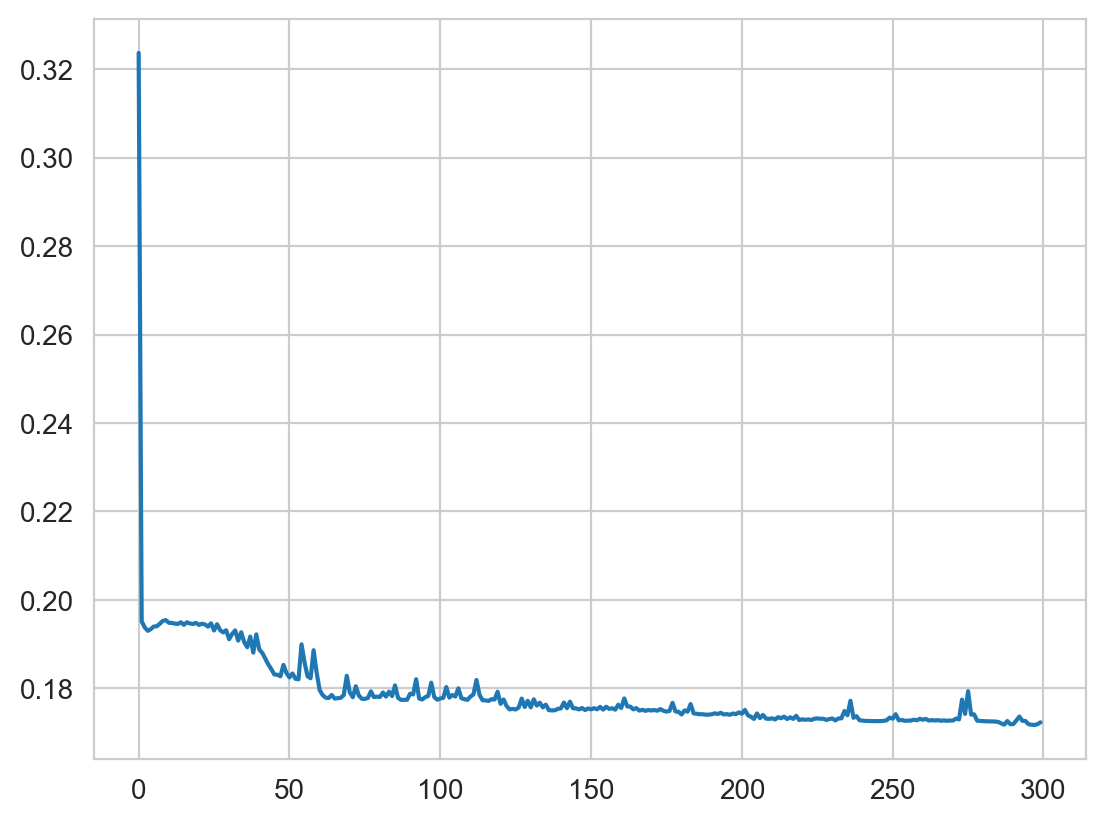

In [205]:
plt.plot(hist_loss)

In [206]:
def plot_skeleton_3d(joint_pos, joint_names):
    bone_list = [['SPINE_CHEST', 'SPINE_NAVEL'],
     ['SPINE_NAVEL', 'PELVIS'],
     ['SPINE_CHEST', 'NECK'],
     ['NECK', 'HEAD'],
     ['HEAD', 'NOSE'],
     ['SPINE_CHEST', 'CLAVICLE_LEFT'],
     ['CLAVICLE_LEFT', 'SHOULDER_LEFT'],
     ['SHOULDER_LEFT', 'ELBOW_LEFT'],
     ['ELBOW_LEFT', 'WRIST_LEFT'],
     ['WRIST_LEFT', 'HAND_LEFT'],
     ['HAND_LEFT', 'HANDTIP_LEFT'],
     ['WRIST_LEFT', 'THUMB_LEFT'],
     ['PELVIS', 'HIP_LEFT'],
     ['HIP_LEFT', 'KNEE_LEFT'],
     ['KNEE_LEFT', 'ANKLE_LEFT'],
     ['ANKLE_LEFT', 'FOOT_LEFT'],
     ['NOSE', 'EYE_LEFT'],
     ['EYE_LEFT', 'EAR_LEFT'],
     ['SPINE_CHEST', 'CLAVICLE_RIGHT'],
     ['CLAVICLE_RIGHT', 'SHOULDER_RIGHT'],
     ['SHOULDER_RIGHT', 'ELBOW_RIGHT'],
     ['ELBOW_RIGHT', 'WRIST_RIGHT'],
     ['WRIST_RIGHT', 'HAND_RIGHT'],
     ['HAND_RIGHT', 'HANDTIP_RIGHT'],
     ['WRIST_RIGHT', 'THUMB_RIGHT'],
     ['PELVIS', 'HIP_RIGHT'],
     ['HIP_RIGHT', 'KNEE_RIGHT'],
     ['KNEE_RIGHT', 'ANKLE_RIGHT'],
     ['ANKLE_RIGHT', 'FOOT_RIGHT'],
     ['NOSE', 'EYE_RIGHT'],
     ['EYE_RIGHT', 'EAR_RIGHT']]
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    
    # Determine which coordinate goes to which axis in the figure
    x, z, y = range(3) 
    
    # Invert the z axis
    ax.invert_zaxis()
    
    joint_names = list(joint_names)

    for bone in bone_list:
        idx_joint_0 = joint_names.index(bone[0])
        idx_joint_1 = joint_names.index(bone[1])
        ax.plot([joint_pos[idx_joint_0][x], joint_pos[idx_joint_1][x]],
                [joint_pos[idx_joint_0][y], joint_pos[idx_joint_1][y]],
                [joint_pos[idx_joint_0][z], joint_pos[idx_joint_1][z]], color='b')

In [207]:
def draw_sample(input):
    with torch.no_grad():
        x_ = input.flatten()
        _, mu, logvar = vae(x_)
        smp = vae.decode(vae.reparameterize(mu, logvar))
        smp = smp.reshape(32, 3)
    return smp


In [212]:
example = train_dataset.x[1200]
smp = draw_sample(example)

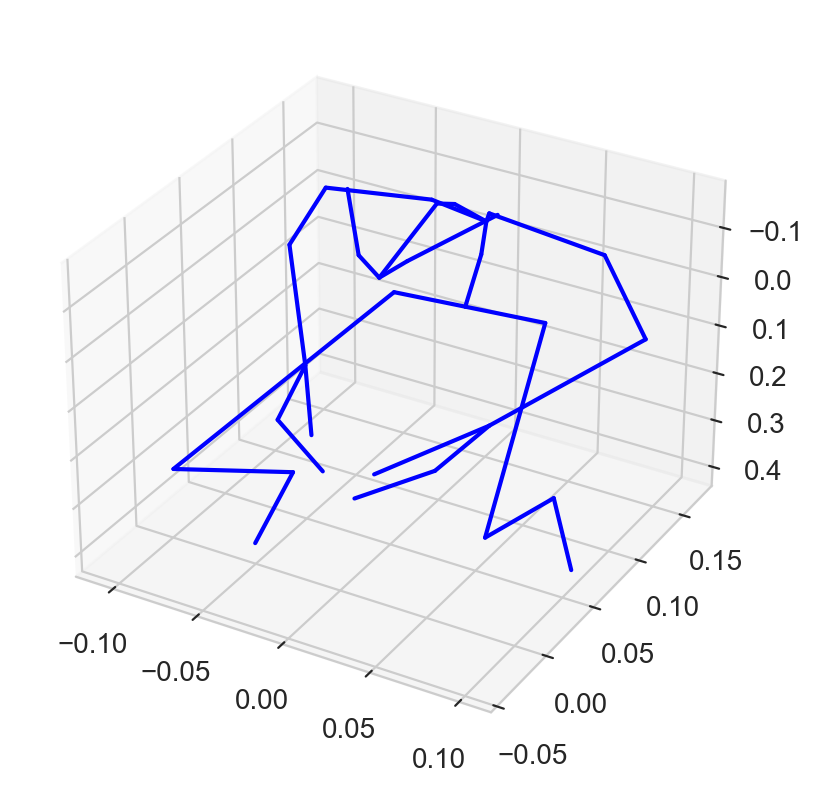

In [213]:
plot_skeleton_3d(example.cpu().numpy(), train_dataset.joint_names)

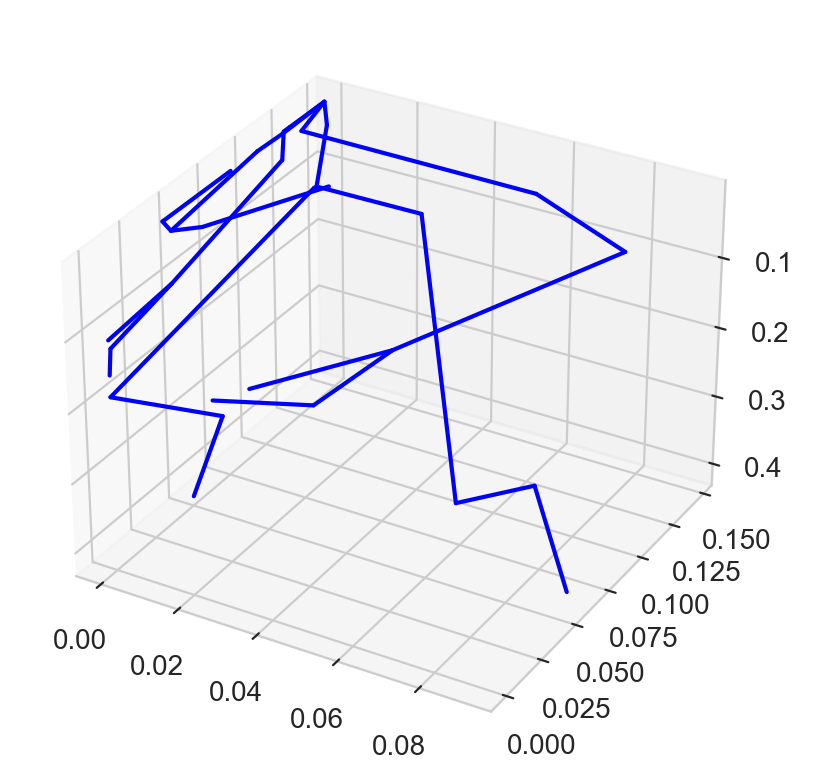

In [214]:
plot_skeleton_3d(smp.cpu().numpy(), train_dataset.joint_names)

In [215]:
pelvis_idx = list(train_dataset.joint_names).index("PELVIS")

In [198]:
len(train_dataset)

2520